In [52]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
v016.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks


In [53]:
import sys, os
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import tqdm

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

In [97]:
# load the true wave image
data_root = '../data/BIOQIC'
wave_base = 'four_target_phantom.mat'
wave_file = data_root + '/' + wave_base
wave_data, rev_axes = mre_pinn.data.load_mat_data(wave_file, verbose=True)

# convert to xarray and add metadata
u_true = np.transpose(data['u_ft'])
u_dims = ['frequency', 'component', 'z', 'x', 'y']
u_coords = {
    'frequency': np.linspace(50, 100, u_true.shape[0]), # Hz
    'x': np.arange(u_true.shape[3]) * 1e-3, # m
    'y': np.arange(u_true.shape[4]) * 1e-3, # m
    'z': np.arange(u_true.shape[2]) * 1e-3, # m
    'component': ['y', 'x', 'z'],
}
u_true = xr.DataArray(u_true, dims=u_dims, coords=u_coords) * 1e-3 # m
u_true = u_true.transpose('frequency', 'x', 'y', 'z', 'component')

# downsampling
ds = 1
u_true = u_true.coarsen(x=ds, y=ds, z=ds).mean()

# single frequency 2D
u_true = u_true.sel(frequency=[60], z=0, component=['x', 'y'])

# single frequency 3D
#u_true = u_true.sel(frequency=[60], component=['x', 'y', 'z'])

# multifrequency 3D
#u_true = u_true.sel(component=['x', 'y', 'z'])

print(np.prod(u_true.shape))
u_true

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
16000


<xarray.DataArray (frequency: 1, x: 80, y: 100, component: 2)>
array([[[[-3.54987721e-15+4.70068174e-15j,
          -1.40539547e-07-1.26790721e-07j],
         [-2.86696146e-15+3.08723745e-15j,
          -2.01890519e-07-3.98395504e-09j],
         [ 0.00000000e+00+0.00000000e+00j,
          -2.38881797e-07+9.20685788e-08j],
         ...,
         [ 0.00000000e+00+0.00000000e+00j,
           1.27499474e-06-3.83990886e-07j],
         [ 7.54510765e-17-8.00958312e-16j,
           1.26002577e-06-3.73149316e-07j],
         [ 0.00000000e+00+0.00000000e+00j,
           1.22505327e-06-3.52941489e-07j]],

        [[ 8.96827099e-08-1.13514917e-07j,
          -1.32552255e-07-1.45164631e-07j],
         [ 7.53837347e-08-8.13587914e-08j,
          -1.90706286e-07-2.59523219e-08j],
         [ 6.56188315e-08-5.50277872e-08j,
          -2.28230418e-07+7.04478221e-08j],
...
         [-1.10374529e-07-9.23145828e-07j,
          -8.14959727e-08+1.39799530e-06j],
         [-1.09997556e-07-9.09463356e-07j,
          -1.36961202e-08+1.23880399e-06j],
         [-1.23367892e-07-9.26021688e-07j,
           2.98841303e-08+1.06783136e-06j]],

        [[-8.12646285e-07-7.09290650e-07j,
          -1.92143971e-07-8.69458900e-07j],
         [-8.03706863e-07-6.00373045e-07j,
          -1.79776557e-07-1.05543393e-06j],
         [-8.10801955e-07-5.26895868e-07j,
          -1.42013706e-07-1.24291501e-06j],
         ...,
         [-3.00958597e-08-9.45729850e-07j,
          -1.42522864e-07+1.55291758e-06j],
         [-4.50838009e-08-9.46362084e-07j,
          -3.75395832e-08+1.38343851e-06j],
         [-7.30770324e-08-9.77355167e-07j,
           2.17137599e-08+1.21215436e-06j]]]])
Coordinates:
  * frequency  (frequency) float64 60.0
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
    z          float64 0.0
  * component  (component) <U1 'x' 'y'

In [98]:
# load the true elastogram
elast_base = 'fem_box_ground_truth.npy'
elast_file = data_root + '/' + elast_base

print(f'Loading {elast_file}')
G_true = np.load(elast_file)
print(G_true.shape, G_true.dtype)

# convert to xarray and add metadata
G_dims = ['frequency', 'z', 'x', 'y']
G_coords = {
    'frequency': np.linspace(50, 100, G_true.shape[0]), # Hz
    'x': np.arange(G_true.shape[2]) * 1e-3, # m
    'y': np.arange(G_true.shape[3]) * 1e-3, # m
    'z': np.arange(G_true.shape[1]) * 1e-3, # m
}
G_true = xr.DataArray(G_true, dims=G_dims, coords=G_coords) # Pa
G_true = G_true.transpose('frequency', 'x', 'y', 'z')

# downsampling
G_true = G_true.coarsen(x=4*ds, y=4*ds, z=ds).mean()

# single 2D slice
G_true = G_true.sel(frequency=[60], z=0)

G_true

Loading ../data/BIOQIC/fem_box_ground_truth.npy
(6, 10, 320, 400) complex128


<xarray.DataArray (frequency: 1, x: 80, y: 100)>
array([[[3000.+376.99111843j, 3000.+376.99111843j, 3000.+376.99111843j,
         ..., 3000.+376.99111843j, 3000.+376.99111843j,
         3000.+376.99111843j],
        [3000.+376.99111843j, 3000.+376.99111843j, 3000.+376.99111843j,
         ..., 3000.+376.99111843j, 3000.+376.99111843j,
         3000.+376.99111843j],
        [3000.+376.99111843j, 3000.+376.99111843j, 3000.+376.99111843j,
         ..., 3000.+376.99111843j, 3000.+376.99111843j,
         3000.+376.99111843j],
        ...,
        [3000.+376.99111843j, 3000.+376.99111843j, 3000.+376.99111843j,
         ..., 3000.+376.99111843j, 3000.+376.99111843j,
         3000.+376.99111843j],
        [3000.+376.99111843j, 3000.+376.99111843j, 3000.+376.99111843j,
         ..., 3000.+376.99111843j, 3000.+376.99111843j,
         3000.+376.99111843j],
        [3000.+376.99111843j, 3000.+376.99111843j, 3000.+376.99111843j,
         ..., 3000.+376.99111843j, 3000.+376.99111843j,
         3000.+376.99111843j]]])
Coordinates:
  * frequency  (frequency) float64 60.0
  * x          (x) float64 0.0015 0.0055 0.0095 0.0135 ... 0.3095 0.3135 0.3175
  * y          (y) float64 0.0015 0.0055 0.0095 0.0135 ... 0.3895 0.3935 0.3975
    z          float64 0.0

<IPython.core.display.Javascript object>


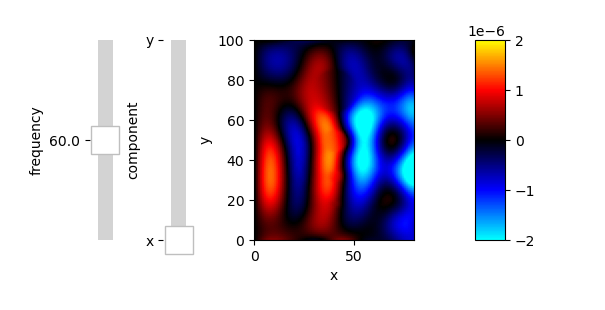

/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks/../mre_pinn/visual.py:363: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  slider = matplotlib.widgets.Slider(


<IPython.core.display.Javascript object>


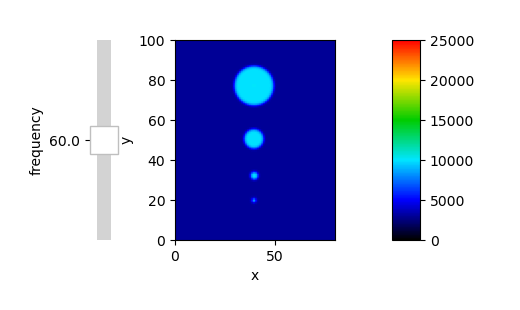

In [99]:
# display true wave field and elastogram
w_map = mre_pinn.visual.wave_color_map()
w_max = 2e-6
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

e_map = mre_pinn.visual.elast_color_map()
e_max = 25e3
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

mre_pinn.visual.NDArrayViewer(u_true.real, dpi=50/ds, **wave_kws)
#mre_pinn.visual.NDArrayViewer(u_true.imag, dpi=50/ds, **wave_kws)
mre_pinn.visual.NDArrayViewer(G_true.real, dpi=50/ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(G_true.imag, dpi=50/ds, **elast_kws)

In [100]:
%autoreload

batch_size = 2000 # collocation points
num_domain =   48 # PDE domain samples

# convert to point set boundary condition
bc = mre_pinn.data.NDArrayBC(u_true, batch_size=batch_size)
x = bc.points
x.shape, bc.values.shape, x.shape[0] / batch_size

((8000, 3), torch.Size([8000, 2]), 4.0)

In [101]:
%autoreload

# set up PDE with geometry and boundary condition
wave_eq = mre_pinn.pde.WaveEquation(detach=True)

# for single frequency, we need to add eps to the geometry range to avoid zero volume
eps = np.zeros(x.shape[1])
eps[0] = 1e-5
geometry = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + eps)

pde = deepxde.data.PDE(geometry, wave_eq, bc, num_domain=num_domain)
train_x = np.array(pde.train_x)
train_x.shape

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+50=50. 
  warnings.warn("The balance properties of Sobol' points require "


(2048, 3)

In [209]:
%autoreload

# define model architecture
parallel = True

if parallel:
    net = mre_pinn.model.Parallel([
        mre_pinn.model.PINN(
            n_input=x.shape[1],
            n_layers=8,
            n_hidden=128,
            n_output=n_output,
            activ_fn=torch.sin,
            complex=True,
            dense=True,
            omega0=32
        ) for n_output in [u_true.shape[-1], 1] # u and mu
    ])
else:
    net = mre_pinn.model.PINN(
        n_input=x.shape[1],
        n_layers=5,
        n_hidden=128,
        n_output=u_true.shape[-1] + 1, # u and mu
        activ_fn=torch.sin,
        complex=True,
        dense=False,
        omega0=32
    )
net

Parallel(
  (0): PINN(
    (linear0): Linear(in_features=3, out_features=128, bias=True)
    (linear1): Linear(in_features=131, out_features=128, bias=True)
    (linear2): Linear(in_features=259, out_features=128, bias=True)
    (linear3): Linear(in_features=387, out_features=128, bias=True)
    (linear4): Linear(in_features=515, out_features=128, bias=True)
    (linear5): Linear(in_features=643, out_features=128, bias=True)
    (linear6): Linear(in_features=771, out_features=128, bias=True)
    (linear7): Linear(in_features=899, out_features=4, bias=True)
  )
  (1): PINN(
    (linear0): Linear(in_features=3, out_features=128, bias=True)
    (linear1): Linear(in_features=131, out_features=128, bias=True)
    (linear2): Linear(in_features=259, out_features=128, bias=True)
    (linear3): Linear(in_features=387, out_features=128, bias=True)
    (linear4): Linear(in_features=515, out_features=128, bias=True)
    (linear5): Linear(in_features=643, out_features=128, bias=True)
    (linear6):

(4,)
[3337.108373    376.99111843] [1.41816046e+03 2.04067874e-11]
(2048, 3) (2048, 4)


<IPython.core.display.Javascript object>


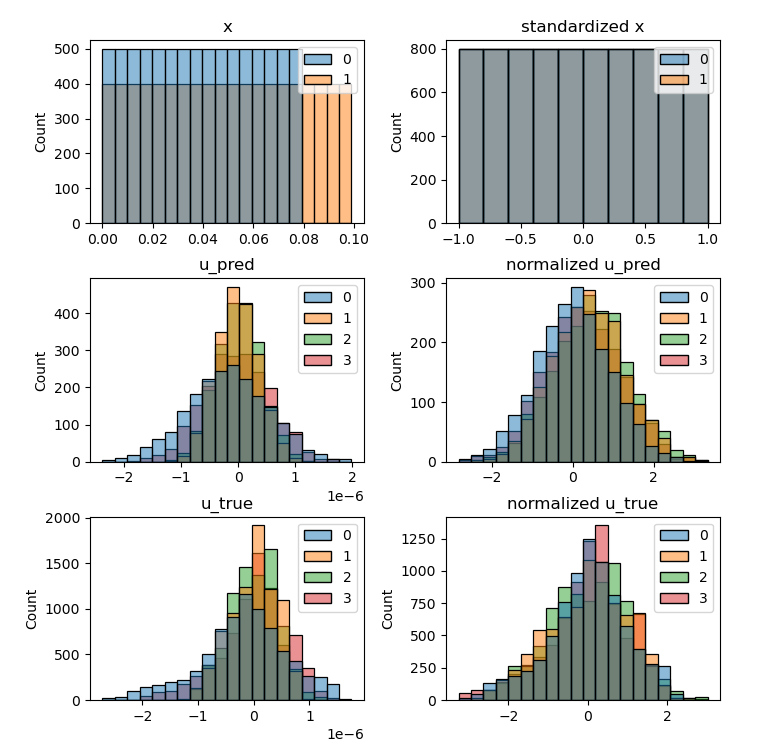

(2048, 4)

In [203]:
import seaborn as sns

# establish data and model weight distribution

# standardize inputs to [-1, 1]
x = bc.points
x_loc = np.mean(x, axis=0)
x_scale = (np.max(x, axis=0) - np.min(x, axis=0)) / 2

if x_scale[0] == 0: # avoid division by zero for single frequency
    x_scale[0] = 1

# normalize outputs with mean and std
u = mre_pinn.model.as_real(bc.values).cpu().numpy()
u_loc = np.mean(u, axis=0)
u_scale = np.std(u, axis=0)
print(u_loc.shape)

mu = torch.as_tensor(G_true.to_numpy()).reshape(-1, 1)
mu = mre_pinn.model.as_real(mu).cpu().numpy()
mu_loc   = np.mean(mu, axis=0)
mu_scale = np.std(mu, axis=0)
print(mu_loc, mu_scale)

output_loc = np.append(u_loc, mu_loc)
output_scale = np.append(u_scale, mu_scale)

# initialize model weights
if parallel:
    net[0].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=u_loc, output_scale=u_scale)
    net[1].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=mu_loc, output_scale=mu_scale)
else:
    net.init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=output_loc, output_scale=output_scale)
    print(output_loc.shape)

# plot distributions of model input and output

outputs = net.forward(torch.as_tensor(train_x).requires_grad_(False)).cpu().detach().numpy()
u_pred  = outputs[:,:-1]
u_pred  = np.stack([u_pred.real, u_pred.imag], axis=-1).reshape(-1, 2*u_pred.shape[1])
mu_pred = outputs[:,-1:]
print(outputs.shape, u_pred.shape)

fig, axes = mre_pinn.visual.subplot_grid(3, 2, 2, 3, space=0.3, pad=[0.9, 0.4, 0.5, 0.4])

# x
axes[0,0].set_title('x')
axes[0,1].set_title('standardized x')
sns.histplot(x[:,1:], bins=20, label='x', ax=axes[0,0])
sns.histplot((x[:,1:] - x_loc[1:]) / x_scale[1:], bins=10, label='x', ax=axes[0,1])

# u_pred
axes[1,0].set_title('u_pred')
axes[1,1].set_title('normalized u_pred')
sns.histplot(u_pred[:,:], bins=20, ax=axes[1,0])
sns.histplot((u_pred[:,:] - u_loc[:1]) / u_scale[:], bins=20, ax=axes[1,1])

# u_true
axes[2,0].set_title('u_true')
axes[2,1].set_title('normalized u_true')
sns.histplot(u[:,:], bins=20, ax=axes[2,0])
sns.histplot((u[:,:] - u_loc[:]) / u_scale[:], bins=20, ax=axes[2,1])

u_pred.shape

In [204]:
%autoreload

# create normalized loss functions
u_norm = torch.norm(bc.values, dim=-1).mean().detach()
print(u_norm)

def normalized_L2_loss(norm):
    def loss_fn(y_true, y_pred):
        return torch.mean(
            torch.norm(y_true - y_pred, dim=-1) / norm
        )
    return loss_fn

pde_loss = normalized_L2_loss(u_norm)
data_loss = normalized_L2_loss(u_norm)

def u_pred_norm(y_true, y_pred):
    '''
    Mean squared norm of predicted displacements.
    '''
    return np.mean(np.linalg.norm(y_pred[:,:-1], axis=-1))

def mu_pred_norm(y_true, y_pred):
    '''
    Mean squared norm of predicted stiffness.
    '''
    return np.mean(np.linalg.norm(y_pred[:,-1:], axis=-1))

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-6, 1],
    loss=[pde_loss, data_loss],
    metrics=[mu_pred_norm, u_pred_norm],
)

tensor(1.0870e-06, dtype=torch.float64)
Compiling model...
'compile' took 0.000171 s



Training model...



/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+50=50. 
  warnings.warn("The balance properties of Sobol' points require "


<IPython.core.display.Javascript object>


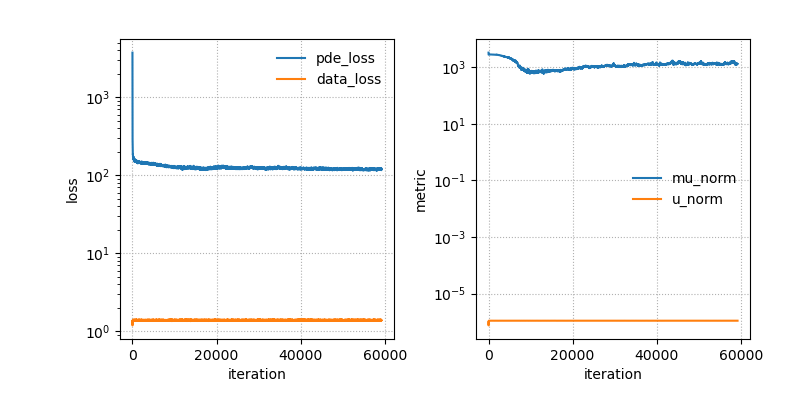

Interrupt


In [205]:
%autoreload

deepxde.display.training_display = mre_pinn.visual.TrainingPlot(
    losses=['pde_loss', 'data_loss'],
    metrics=['mu_norm', 'u_norm']
)

class BatchResampler(deepxde.callbacks.Callback):
    
    def on_batch_end(self):
        self.model.data.train_x_bc = None
        self.model.data.resample_train_points()

try:
    model.train(100000, display_every=10, callbacks=[BatchResampler()])
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

100%|██████████| 4/4 [00:00<00:00, 12.91it/s]


<IPython.core.display.Javascript object>


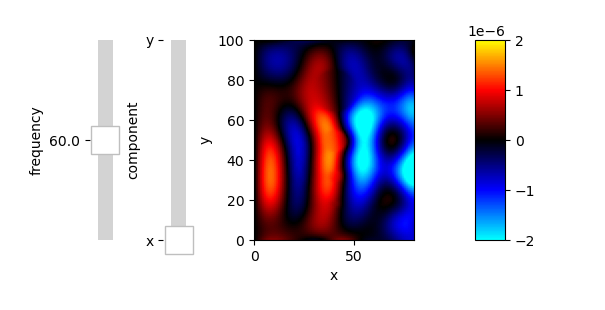

/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks/../mre_pinn/visual.py:363: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  slider = matplotlib.widgets.Slider(


<IPython.core.display.Javascript object>


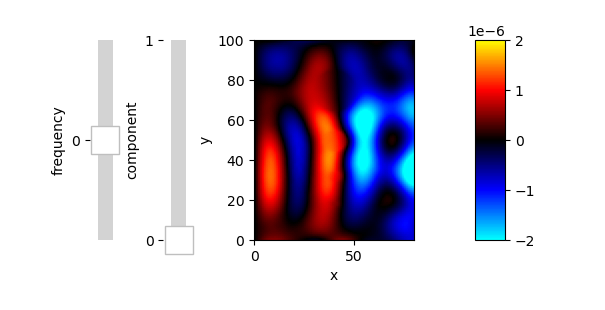

<IPython.core.display.Javascript object>


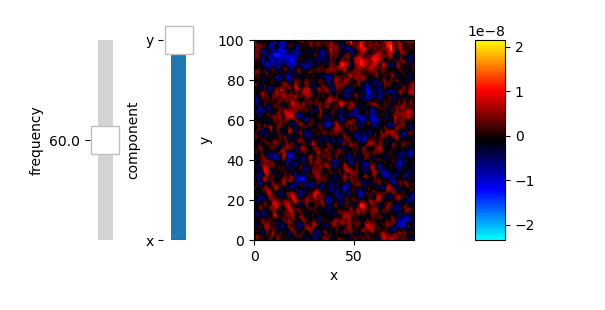

In [206]:
# train one step
#model.train(10, display_every=10, callbacks=[BatchResampler()])
#print(model.train_state.step)

def minibatch(func, batch_size):
    def wrapper(*args, **kwargs):
        n = args[0].shape[0]
        outputs = []
        for i in tqdm.tqdm(range(0, n, batch_size)):
            batch_args = [a[i:i+batch_size] for a in args]
            output = func(*batch_args, **kwargs)
            outputs.append(output)
        return np.concatenate(outputs, axis=0)
    return wrapper

def laplacian_u(x, outputs):
    u = outputs[:,:-1]
    lu = mre_pinn.pde.laplacian(u, x, dim=1)
    deepxde.gradients.clear()
    return lu

batch_predict = minibatch(model.predict, batch_size)

# model predictions
x = bc.points
outputs = batch_predict(x)
u_pred  = outputs[:,:-1].reshape(u_true.shape)
mu_pred = outputs[:,-1:].reshape(u_true.shape[:-1])
lu_pred = batch_predict(x, operator=laplacian_u).reshape(u_true.shape)

# display wave field
w_map = mre_pinn.visual.wave_color_map()
w_max = 2e-6
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

mre_pinn.visual.NDArrayViewer(u_true.real, labels=u_true.dims, dpi=50/ds, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_pred.real, labels=u_true.dims, dpi=50/ds, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_true.real - u_pred.real, labels=u_true.dims, dpi=50/ds,cmap=w_map)

<IPython.core.display.Javascript object>


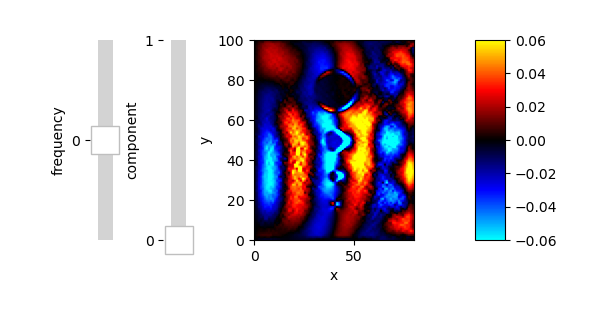

<IPython.core.display.Javascript object>


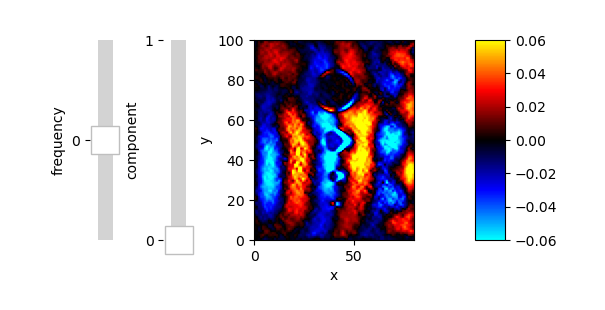

<IPython.core.display.Javascript object>


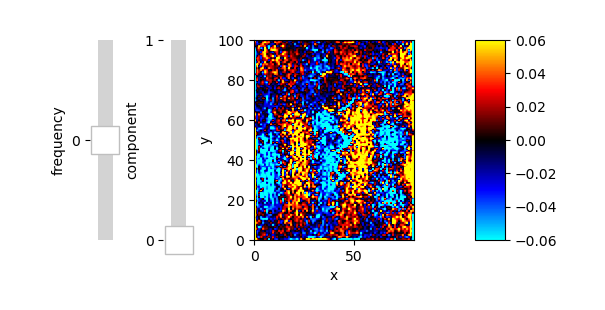

<IPython.core.display.Javascript object>


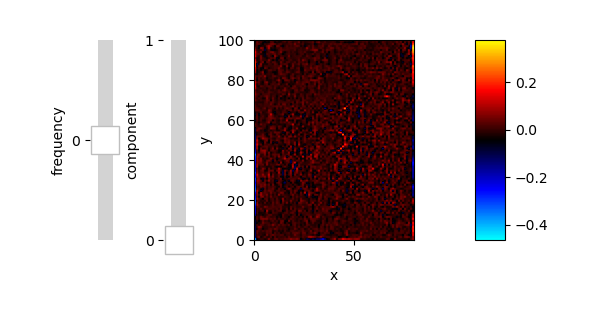

In [207]:
# compute discrete laplacian of wave field

def discrete_laplacian(u, resolution=1, dim=0):
    '''
    Discrete Laplacian operator.
    '''
    components = []
    grad = np.gradient
    for i in range(u.shape[-1]):
        component = 0
        for j in range(dim, len(u.shape) - 1):
            component += grad(grad(u[...,i], axis=j), axis=j) / resolution**2
        components.append(component)
    return np.stack(components, axis=-1)

Lu_true = discrete_laplacian(u_true, resolution=1e-3, dim=1)
Lu_pred = discrete_laplacian(u_pred, resolution=1e-3, dim=1)

# display wave field laplacians
L_max = 6e-2
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

mre_pinn.visual.NDArrayViewer(Lu_true.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
mre_pinn.visual.NDArrayViewer(Lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
mre_pinn.visual.NDArrayViewer(lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
mre_pinn.visual.NDArrayViewer(Lu_true.real - lu_pred.real, labels=u_true.dims, dpi=50/ds, cmap=w_map)

<IPython.core.display.Javascript object>


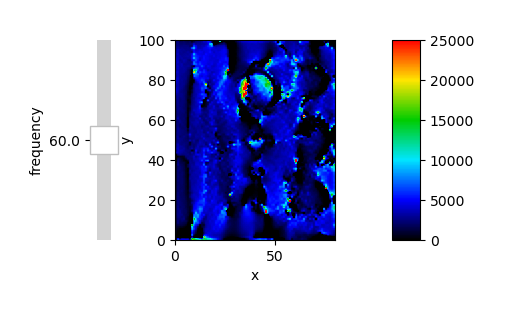

/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks/../mre_pinn/visual.py:363: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  slider = matplotlib.widgets.Slider(


<IPython.core.display.Javascript object>


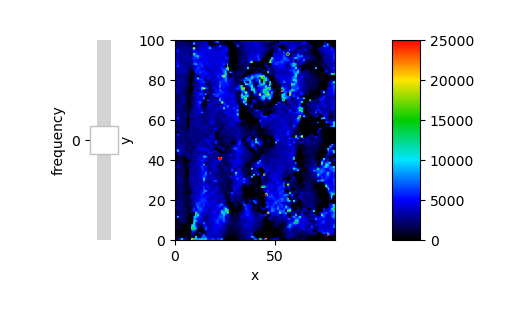

<IPython.core.display.Javascript object>


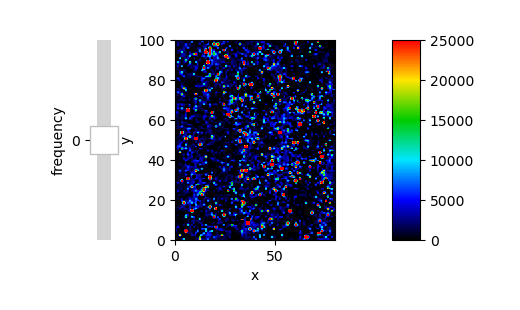

<IPython.core.display.Javascript object>


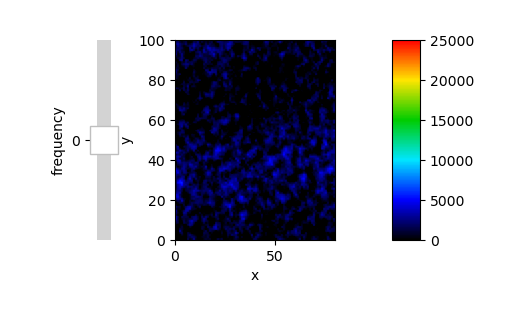

In [208]:
from scipy.ndimage import gaussian_filter

# compare elastograms

def direct_inversion(u, Lu, omega, rho=1000):
    return (-rho * (2*np.pi*omega)**2 * u / Lu).mean(axis=-1)

omega = u_true.frequency.to_numpy().reshape(-1, 1, 1, 1)
mu_data = direct_inversion(u_true, Lu_true, omega) #.mean(axis=0)
mu_u_Lu = direct_inversion(u_pred, Lu_pred, omega) #.mean(axis=0)
mu_u_lu = direct_inversion(u_pred, lu_pred, omega) #.mean(axis=0)

# display elastogram
e_map = mre_pinn.visual.elast_color_map()
e_max = 25e3
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

mre_pinn.visual.NDArrayViewer(mu_data.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_u_Lu.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_u_lu.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_pred.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(mu_data.real - mu_pred.real, labels=u_true.dims[1:-1], dpi=50/ds, cmap=w_map)

<IPython.core.display.Javascript object>


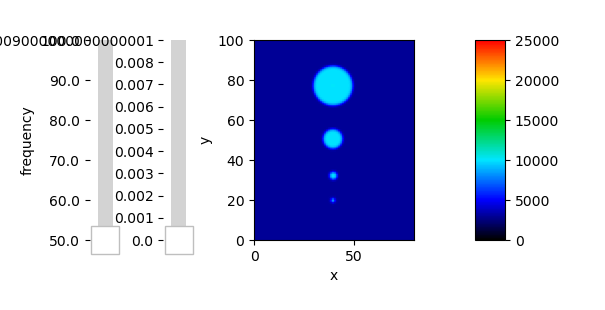